# 1. Recap

In the past mission, you removed all of the columns that 
* contained redundant information,
* weren't useful for modeling, 
* required too much processing to make useful,
* or leaked information from the future.

In this mission, we'll prepare the data for machine learning by focusing on `handling missing values, converting categorical columns to numeric columns, and removing any other extraneous columns` we encounter throughout this process.

`This is because the mathematics underlying most machine learning models assumes that the data is numerical and contains no missing values. To reinforce this requirement, scikit-learn will return an error if you try to train a model using data that contain missing values or non-numeric values when working with models like linear regression and logistic regression.`

## TODO
* Read in filtered_loans_2007.csv as a Dataframe and assign it to loans.
* Use the isnull and sum methods to return the number of null values in each column. Assign the resulting Series object to null_counts.

In [1]:
import pandas as pd

loans=pd.read_csv('filtered_loans_2007.csv')

null_counts=loans.isnull().sum()
print(null_counts)

loan_amnt                  0
term                       0
int_rate                   0
installment                0
emp_length              1036
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64


# 2. Handling missing values

loan_amnt 0.0
term 0.0
int_rate 0.0
installment 0.0
emp_length 267.2169202992004
home_ownership 0.0
annual_inc 0.0
verification_status 0.0
loan_status 0.0
purpose 0.0
title 2.837245292752128
addr_state 0.0
dti 0.0
delinq_2yrs 0.0
earliest_cr_line 0.0
inq_last_6mths 0.0
open_acc 0.0
pub_rec 0.0
revol_bal 0.0
revol_util 12.896569512509673
total_acc 0.0
last_credit_pull_d 0.5158627805003869
pub_rec_bankruptcies 179.77817900438484


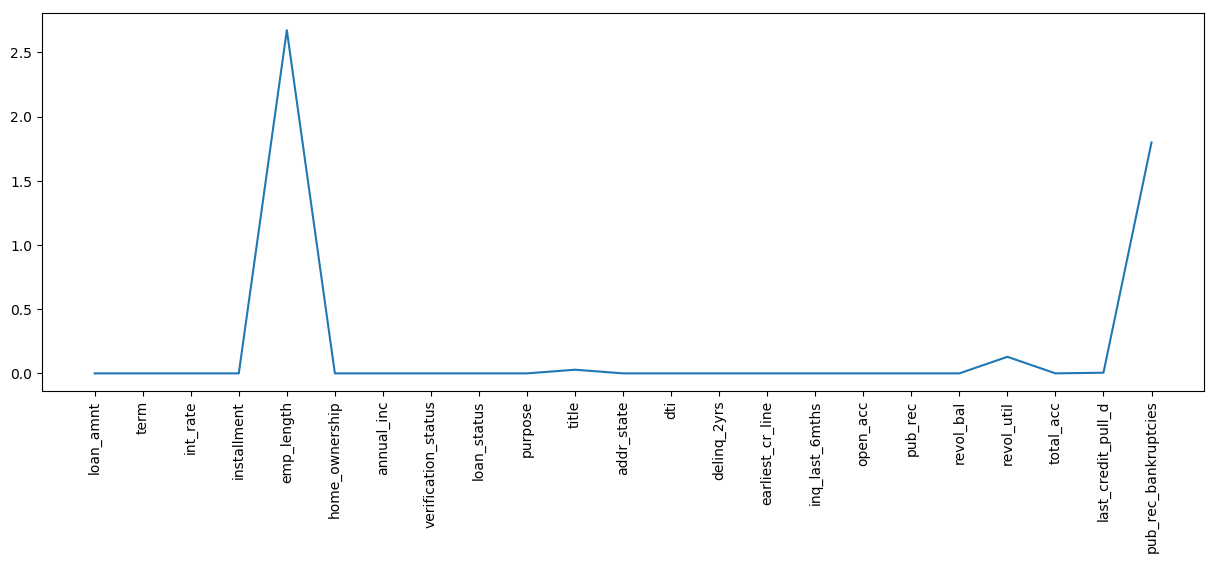

In [2]:
null_perc={}

for col in null_counts.index:
    missing_value_perc=null_counts[col]/len(loans[col])*100
    null_perc[col]=missing_value_perc
    print(col,missing_value_perc*100)
    
    
# visualize missiing values in columns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

figure(num=None, figsize=(15, 5), dpi=100, facecolor='w', edgecolor='k')

plt.plot(null_counts.index,null_perc.values())
plt.xticks(rotation=90);

Two columns, `emp_length` and `pub_rec_bankruptcies`, contain a relatively high amount of missing values.

Domain knowledge tells us that employment length is frequently used in assessing how risky a potential borrower is, so we'll `keep this column despite its relatively large amount of missing values.`

In [3]:
print(loans.pub_rec_bankruptcies.value_counts(normalize=True, dropna=False))

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64


We see that this column `offers very little variability`, nearly 94% of values are in the same category. It probably won't have much predictive value. Let's drop it. 

This means that we'll keep the following columns and just remove rows containing missing values for them:
* emp_length
* title
* revol_util
* last_credit_pull_d

and drop the pub_rec_bankruptcies column entirely.

## TODO:
* Use the drop method to remove the pub_rec_bankruptcies column from loans.
* Use the dropna method to remove all rows from loans containing any missing values.
* Use the dtypes attribute followed by the value_counts() method to return the counts for each column data type. Use the print function to display these counts.

In [4]:
loans=loans.drop('pub_rec_bankruptcies',axis=1)
loans=loans.dropna()
loans.dtypes

loan_amnt              float64
term                    object
int_rate                object
installment            float64
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
loan_status              int64
purpose                 object
title                   object
addr_state              object
dti                    float64
delinq_2yrs            float64
earliest_cr_line        object
inq_last_6mths         float64
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util              object
total_acc              float64
last_credit_pull_d      object
dtype: object

In [5]:
loans.dtypes.value_counts()

object     11
float64    10
int64       1
dtype: int64

# 3. Text columns

While the numerical columns can be used natively with scikit-learn, the object columns that contain text need to be converted to numerical data types. 

You can use the Dataframe method [select_dtypes](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) to select only the columns of a certain data type:

## TODO:
* Use the Dataframe method select_dtypes to select only the columns of object type from loans and assign the resulting Dataframe object_columns_df.
* Display the first row in object_columns_df using the print function.

In [6]:
object_columns_df=loans.select_dtypes(include=['object'])
object_columns_df.iloc[0]

term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Jun-2016
Name: 0, dtype: object

# 4. Converting text columns

Some of the columns seem like they represent categorical values, but we should confirm by checking the number of unique values in those columns:

* home_ownership: home ownership status, can only be 1 of 4 categorical values according to the data dictionary,
* verification_status: indicates if income was verified by Lending Club,
* emp_length: number of years the borrower was employed upon time of application,
* term: number of payments on the loan, either 36 or 60,
* addr_state: borrower's state of residence,
* purpose: a category provided by the borrower for the loan request,
* title: loan title provided by the borrower,

There are also some columns that represent numeric values, that need to be converted:

* int_rate: interest rate of the loan in %,
* revol_util: revolving line utilization rate or the amount of credit the borrower is using relative to all available credit, read more here.

Lastly, some of the columns contain date values that would require a good amount of feature engineering for them to be potentially useful:

* earliest_cr_line: The month the borrower's earliest reported credit line was opened,
* last_credit_pull_d: The most recent month Lending Club pulled credit for this loan.

# 5. First 5 categorical columns

## TODO:
* Display the unique value counts for the following columns: home_ownership, verification_status, emp_length, term, addr_state columns:
* Store these column names in a list named cols.
* Use a for loop to iterate over cols:
* Use the print function combined with the Series method value_counts to display each column's unique value counts.

In [7]:
cols=['home_ownership','verification_status','emp_length','term','addr_state']

for col in cols:
    print(loans[col].value_counts())

RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64
10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64
 36 months    28234
 60 months     9441
Name: term, dtype: int64
CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
AL     420
LA     420
KY     311
OK     285
KS     249
UT     249
AR     229
DC     209
RI     194
NM     180
WV     164
HI     162
NH     157
DE     110
MT      77
WY      76
AK      76
SD      60
VT  

# 6. The reason for the loan

The home_ownership, verification_status, emp_length, term, and addr_state columns all contain multiple discrete values. `We should clean the emp_length column and treat it as a numerical one` since the values have ordering (2 years of employment is less than 8 years)

First, let's look at the unique value counts for the purpose and title columns to understand which column we want to keep.

In [8]:
print(loans['title'].value_counts())
print(loans['purpose'].value_counts())

Debt Consolidation                           2068
Debt Consolidation Loan                      1599
Personal Loan                                 624
Consolidation                                 488
debt consolidation                            466
Credit Card Consolidation                     345
Home Improvement                              336
Debt consolidation                            314
Small Business Loan                           298
Credit Card Loan                              294
Personal                                      290
Consolidation Loan                            250
Home Improvement Loan                         228
personal loan                                 219
Loan                                          202
Wedding Loan                                  199
personal                                      198
Car Loan                                      188
consolidation                                 186
Other Loan                                    168


# 7. Categorical columns

The home_ownership, verification_status, emp_length, and term columns each contain a few discrete categorical values. `We should encode these columns as dummy variables and keep them`.

It seems like the purpose and title columns `do contain overlapping information but we'll keep the purpose column since it contains a few discrete values`. In addition, the title column has data quality issues since many of the values are repeated with slight modifications (e.g. Debt Consolidation and Debt Consolidation Loan and debt consolidation).

## TODO:
* Remove the last_credit_pull_d, addr_state, title, and earliest_cr_line columns from loans.
* Convert the int_rate and revol_util columns to float columns by:
  * Using the str accessor followed by the rstrip string method to strip the right trailing percent sign (%):
    * loans['int_rate'].str.rstrip('%') returns a new Series with % stripped from the right side of each value.
  * On the resulting Series object, use the astype method to convert to the float type.
  * Assign the new Series of float values back to the respective columns in the Dataframe.
* Use the replace method to clean the emp_length column.

In [9]:
loans=loans.drop(['last_credit_pull_d','addr_state','title','earliest_cr_line'],axis=1)
loans['int_rate']=loans['int_rate'].str.rstrip('%').astype(float)
loans['revol_util']=loans['revol_util'].str.rstrip('%').astype(float)  

In [10]:
loans['int_rate'].head()

0    10.65
1    15.27
2    15.96
3    13.49
4     7.90
Name: int_rate, dtype: float64

In [11]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
    }

loans=loans.replace(mapping_dict)
loans.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,36 months,10.65,162.87,10,RENT,24000.0,Verified,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0
1,2500.0,60 months,15.27,59.83,0,RENT,30000.0,Source Verified,0,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0
2,2400.0,36 months,15.96,84.33,10,RENT,12252.0,Not Verified,1,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0
3,10000.0,36 months,13.49,339.31,10,RENT,49200.0,Source Verified,1,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0
4,5000.0,36 months,7.90,156.46,3,RENT,36000.0,Source Verified,1,wedding,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0


# 8. Dummy variables

Let's now encode the home_ownership, verification_status, purpose, and term columns as dummy variables so we can use them in our model. We first need to use the Pandas get_dummies method to return a new Dataframe containing a new column for each dummy variable:

In [12]:
dummy_cols=pd.get_dummies(['home_ownership','verification_status','purpose','term'])

loans=pd.concat([loans,dummy_cols],axis=1)
loans=loans.drop(loans[['home_ownership','verification_status','purpose','term']],axis=1)
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,10.65,162.87,10,24000.0,1,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0
1,2500.0,15.27,59.83,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0
2,2400.0,15.96,84.33,10,12252.0,1,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0
3,10000.0,13.49,339.31,10,49200.0,1,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0
4,5000.0,7.90,156.46,3,36000.0,1,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0
